# Ordinary differential equations

For the rest of the lecture we will discuss a few different methods for solving ordinary differential equations. You were introduced to this in your lecture on symbolic manipulations; this segment will go further into detail, and focus on approaches to a few different types of problems.

An ordinary differential equation of order $N$ can generically be written as a system of first-order equations

\begin{equation}\label{eq:ode}
    \frac{\text{d}y_i(x)}{\text{d}x}
    =F_i(x,y_0,...,y_i,...,y_{N-1}),
\end{equation}

where $F_i$ are functions of at least $x$ and the solution variables $y_i$, and are algebrac (i.e. don't involve derivatives) in $x$. 

The approach taken to solve such a system depends primarily on (i) the nature of the boundary conditions involved, (ii) whether or not $F_i$ involve unknown parameters aside from $x$ and $y_i$ (e.g. eigenvalues). More generally, the $F_i$ can involve derivatives/integrals in independent variables other than $x$, in which case the system above would constitute a system of partial differential equations.


## Initial value problems

A system of ordinary differential equations constitutes an initial value problem (IVP) when the values of the $y_i$ are specified at some initial value of $x_0$. The goal of an initial value problem is to "integrate'' (i.e. solve) the system from $x=x_0$ to some end-state $x=x_f$. Frequently (but not always) the independent variable in IVPs is time, so we might write $x=t$.


## First example

The approaches we took to integrating and differentiating functions can be applied directly to solving differential equations. For first example, consider the first-order ODE 

$$ \frac{dy}{dt} = -ay $$

where $a$ is a constant (i.e., $F(t,y)=-ay$). Together with the initial condition $y(0) = 1$, this ODE constitutes an initial value problem, with the analytical solution $y(t) = e^{-at}$. 


## Finite differences approach

Let's use finite differences to integrate this equation through from time $t_0=0$ to $t_f=1.$ Applying forward finite differences at some time $t=t_i$, we can write

\begin{align}
    y'(t_i+h)
    \simeq \frac{1}{h}[y(t_i+h) - y(t_i)]
    =F(t_i,y(t_i)),
\end{align}

where $h$ is a small timestep. Then we can compute $y$ at time $t_i+h$ from $y$ at time $t_i$ from

\begin{equation}
    y(t_i+h)=y(t_i) + hF(t_i,y(t_i)).
\end{equation}

The following function implements this iteration scheme:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})

def integrateIVP(fun,t_span,y0,h):
    '''
        uses forward finite-differences (Euler's method) to integrate a 
        single ODE from a provided initial value.
        
            rhf:     righthand-side function for an ODE of form y'(t)=rhf(t,y)
            t0:      tuple (t0,tf) of initial/final values of independent variable t
            y0:      initial value of solution at t=t0
            h:       step-size for t
    '''

    # define function to compute y_i+1 from y_i:
    def iterate(yi):
        return yi + h*fun(yi)

    # set initial conditions at t=t0:
    t0,tf = t_span
    tt = np.linspace(t0,tf,int((tf-t0)/h)+1)
    yy = [y0]

    # integrate forward in time to t=tf:
    for i,t in enumerate(tt[1:]):
        yy.append(iterate(yy[i]))
        
    return tt,np.array(yy)

This works reasonably well, at least for our simple example: the following code integrates the IVP $\dot{y}=-ay$ for a variety of values for $a$, and plots the solutions and their associated deviations from the true solution:

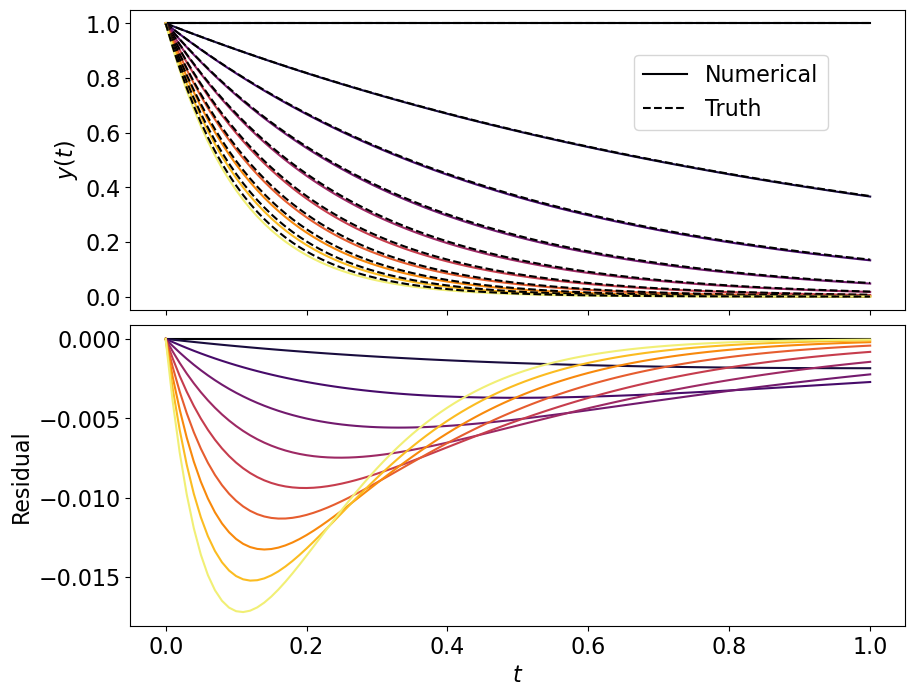

In [2]:
# RHS function:
def F(y,a):
    return -a*y

# compute and plot solutions & residuals:
cols = plt.cm.inferno(np.linspace(0,.95,10))
f,ax = plt.subplots(2,1,figsize=(10,8),sharex=True)
for i,aa in enumerate(np.arange(10)):
    tt,yy = integrateIVP(fun=lambda y: F(y,a=aa),t_span=(0,1.),y0=1,h=0.01)
    ax[0].plot(tt,yy,label='Numerical' if i==0 else '__nolegend__',color=cols[i])
    ax[0].plot(tt,np.exp(-aa*tt),'--',label='Truth' if i==0 else '__nolegend__',color='k')    
    ax[1].plot(tt,yy-np.exp(-aa*tt),color=cols[i])
ax[1].set_xlabel('$t$')
ax[0].set_ylabel('$y(t)$')
ax[1].set_ylabel('Residual')
ax[0].legend(loc=(0.65,0.6))
plt.subplots_adjust(hspace=0.05)

The total error in the solution scales inversely with the step-size, $h$:

Text(0, 0.5, 'Error')

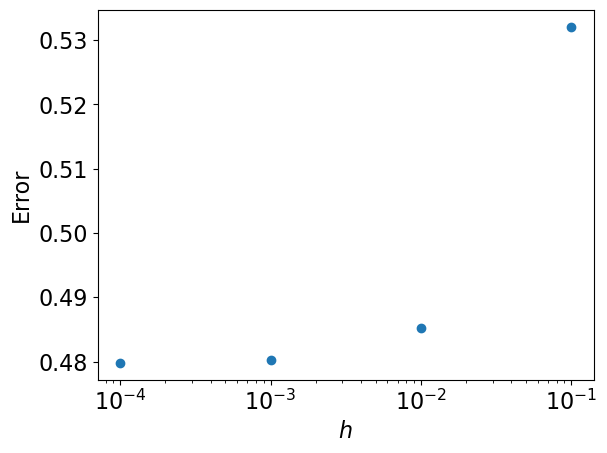

In [3]:
# compute and plot cumulative errors:
errs = []
Nvals= [10,100,1000,10000]
hvals= [1./N for N in Nvals]
for h in hvals:    
    tt,yy = integrateIVP(fun=lambda y: F(y,a=5),t_span=(0,1.),y0=1,h=h)
    errs.append(np.sum(abs(yy - np.exp(-5*tt))))
    
plt.figure()
plt.semilogx(hvals,errs,'o')
plt.xlabel('$h$')
plt.ylabel('Error')

### Exercise 6

As we discussed, forward finite differences constitute a first-order (i.e. fairly inaccurate) method. We can improve on this by switching to centred finite differences. However, getting started requires some finagling at $t=t_0$: applying centred finite differences at $t=t_i+h/2$ for some small $h$,

\begin{align}
    y'(t+h/2)
    &=y'(t_i+h)
    \simeq\frac{1}{h}[y(t+h/2) - y(t-h/2)]
    =\frac{1}{h}[y(t_i+h) - y(t_i)]
\\
    &=F[t_i+h/2,y(t_i+h/2)],
\\
    &\approx F[t_i+h/2,y(t_i) + (h/2)y'(t_i)],
\\
    &=F[t_i + h/2,y(t_i) + (h/2)F(t_i,y(t_i))],
\end{align}

where second to last approximate equality involves a Taylor expansion of $y(t_i+h/2)$. We can then use the iteration scheme

\begin{equation}
    y(t_i+h)
    =y(t_i) + hF\left[
        t_i + \frac{h}{2},y(t_i) + \frac{h}{2}F(t_i,y(t_i))
    \right]
\end{equation}

Write a new function, integrateIVP2, that updates integrateIVP to use this second-order scheme. How do the results compare? How might we generalize this approach further to allow for more general RHS functions?

## SciPy IVP integrators

First and second order finite differences work reasonably well for the simple IVP above, but frequently the problems we encounter in astrophysics are much less nicely behaved. The package scipy.integrate includes a few ODE integrators that are more accurate (although frequently even these run into problems). The simulation code Rebound (https://rebound.readthedocs.io/en/latest/) also has some integrators that work quite well (https://rebound.readthedocs.io/en/latest/ipython_examples/IntegratingArbitraryODEs/)

The default scipy function for solving initial value problems is scipy.integrate.solve_ivp. Let's use this to produce the same results as above:

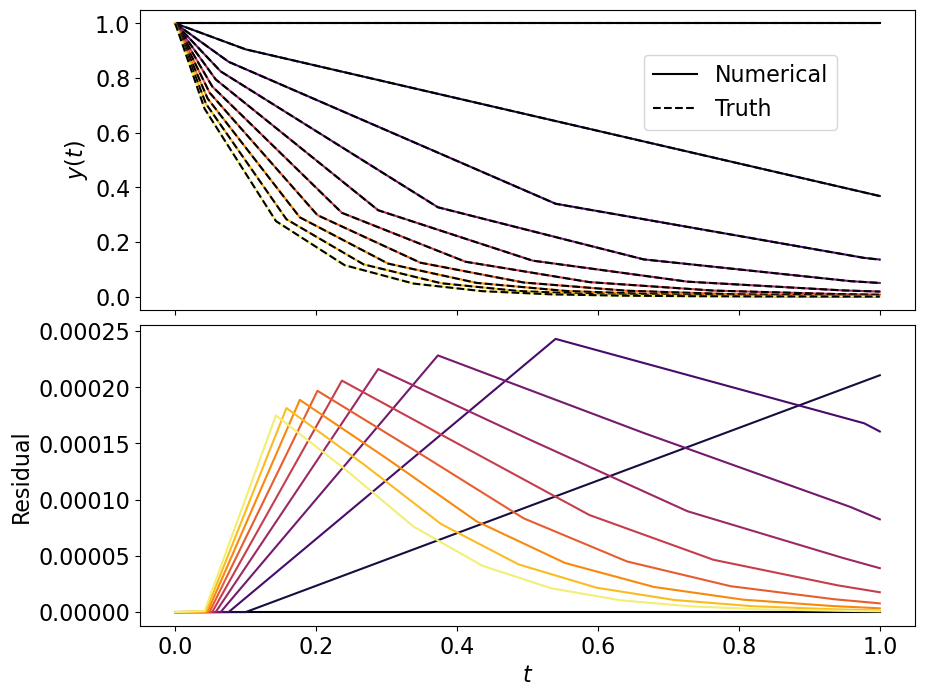

In [4]:
from scipy.integrate import solve_ivp

# RHS function:
def F(y,a):
    return -a*y

# compute and plot solutions & residuals:
cols = plt.cm.inferno(np.linspace(0,.95,10))
f,ax = plt.subplots(2,1,figsize=(10,8),sharex=True)
f = lambda x: x**2
def f(x):
    re
for i,aa in enumerate(np.arange(10)):
    sol = solve_ivp(fun=lambda t,y: -aa*y,t_span=[0,1],y0=[1.])
    ax[0].plot(sol.t,sol.y[0],label='Numerical' if i==0 else '__nolegend__',color=cols[i])
    ax[0].plot(sol.t,np.exp(-aa*sol.t),'--',label='Truth' if i==0 else '__nolegend__',color='k')    
    ax[1].plot(sol.t,sol.y[0]-np.exp(-aa*sol.t),color=cols[i])
ax[1].set_xlabel('$t$')
ax[0].set_ylabel('$y(t)$')
ax[1].set_ylabel('Residual')
ax[0].legend(loc=(0.65,0.6))
plt.subplots_adjust(hspace=0.05)

I intentionally defined integrateIVP to take similar arguments to scipy.integrate.solve_ivp, with some important differences: first of all, solve_ivp adaptively chooses an appropriate stepsize, so we don't need to specify one. The above plots of solutions may look choppy, but the residuals are small (if we like, we can pass an array of desired grid-points as "t_eval"). By default, solve_ivp uses a 4th order "Runge-Kutta" method.

Importantly, solve_ivp supports the integration of systems of equations, specified through rhs functions ("fun") with that accept/return vector input/output for $y$. Let's use this to integrate the equation for a damped harmonic oscillator:

$$ m \frac{d^2 y}{dt^2} + c \frac{dy}{dt} + ky = 0 $$

Since this is a second order ODE, we need to split into two first order ODEs before using solve_ivp to integrate it. Introducing the dummy variable $v=\dot{y}$, 

\begin{equation}
    \dfrac{\text{d}\vec{\bf y}}{\text{d}t}=\left[
        \begin{matrix}
            \dot{y} \\ \dot{v}
        \end{matrix}
    \right]
    =\left[
        \begin{matrix}
            v \\ -(c/m)v - (k/m)y
        \end{matrix}
    \right]
    =\vec{\bf F}(t,{\bf y})
\end{equation}

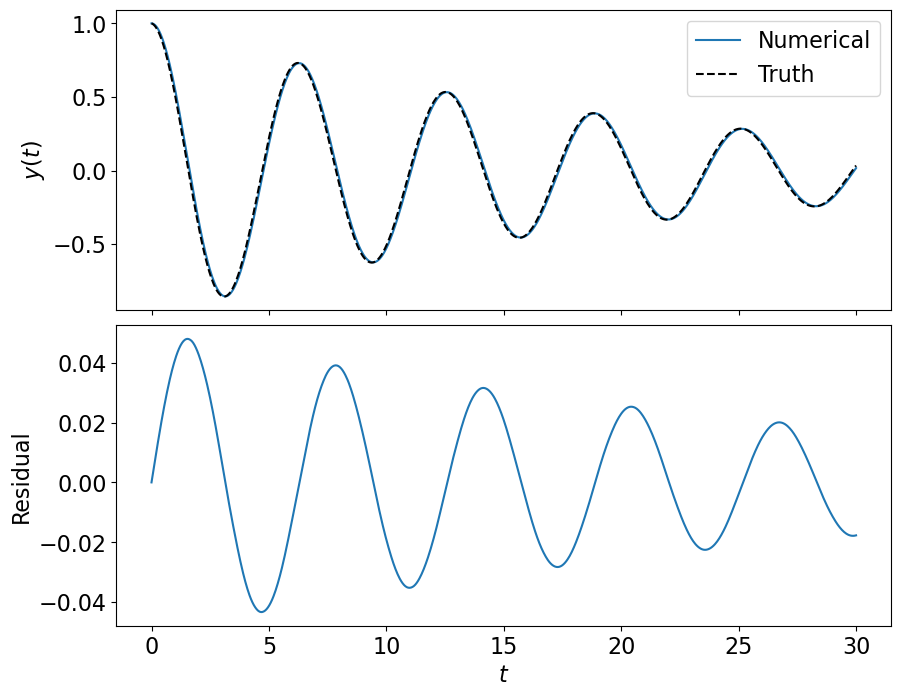

In [5]:
"""
Integrate the damped harmonic oscillator with Scipy
"""
from scipy.integrate import solve_ivp

def damped_oscillator(t, y, m, c, k):
    """
    Function for the damped harmonic oscillator.
    
    Parameters:
    t: Time
    y: Array of [y, v=\dot{y}]
    m: mass
    c: damping coefficient
    k: spring constant
    """
    
    return [y[1], -1/m * (c*y[1] + k*y[0])]

# Set the initial conditions, lets do x=1, v=0
y0 = [1.0, 0.0]
t_span = [0.0,30]

# Choose parameter values for  m, c, k
args = (1.0,0.1,1.0)

# evaluation values for t (the solver may not use these, but it will 
# return solution evaluated on them):
t = np.linspace(t_span[0], t_span[1], 1000)

# analytical answer:
m,c,k = args
ans = np.exp(-c/(2 * m) * t) * np.cos(np.sqrt(k/m) * t)

# integrate the equation:
sol = solve_ivp(fun=damped_oscillator,y0=y0,t_span=t_span,args=args,t_eval=t)

# plot the results:
f,ax = plt.subplots(2,1,figsize=(10,8),sharex=True)
ax[0].plot(sol.t,sol.y[0],label='Numerical')
ax[0].plot(t,ans,'k--',label='Truth')
ax[1].plot(t,sol.y[0]-ans)
ax[1].set_xlabel('$t$')
ax[0].set_ylabel('$y(t)$')
ax[1].set_ylabel('Residual')
ax[0].legend()
plt.subplots_adjust(hspace=0.05)

## The Hamiltonian of The Pendulum

For a slightly more involved example, consider the hamiltonian of the pendulum. We can integrate this in phase space and explore some of the properties of the integrators for energy conservation. The relevant equations are:

### The Hamiltonian of the pendulum

#### $L = \frac{1}{2} m (l\dot\theta)^2 - mgl(1-\cos\theta)$

#### $p = \partial L/\partial \dot\theta = m l^2 \dot\theta$

#### $H = p\dot\theta - L = \frac{p^2}{2ml^2} - mgl\cos\theta$

#### $\frac{d\theta}{dt}= \frac{\partial H}{\partial p} = \frac{p}{ml^2}$

#### $\frac{d p}{dt} = -\frac{\partial H}{\partial \theta} = -mgl\sin\theta$

So our system of equations is

\begin{equation}
    \left[ 
        \begin{matrix}
            \dot{\theta} \\ \dot{p}
        \end{matrix}
    \right]
    =
    \left[ 
        \begin{matrix}
             p/(ml^2) \\
             -mgl\sin\theta
        \end{matrix}
    \right]
\end{equation}

In [6]:
def pendulum(t, y, m, g, l):
    """
    Function the rhs of the ODES for dtheta/dt and dp/dt in the Hamiltonian
    of the pendulum.
    """
    theta, p = y
    
    return [p / (m * l**2), -m * g * l * np.sin(theta)]

In [7]:
def energy_theta_p(theta, p):
    """
    Energy of the pendulum given the coordinates theta and p.
    """
    kinetic_energy = 0.5 * p**2 / (m * l**2)
    potential_energy = -m * g * l * np.cos(theta)
    return(kinetic_energy, potential_energy, kinetic_energy + potential_energy)

def energy_y(y):
    """
    Wrapper function for the energy in terms of the vector y.
    """
    theta, p = y
    return energy_theta_p(theta, p)

def mod_2pi(theta):
    """
    Make sure theta is always within (0, 2*pi).
    """
    theta = np.mod(theta, 2.*np.pi)
    theta = np.where(theta > np.pi, theta - 2.*np.pi, theta)
    theta = np.where(theta < - np.pi, theta + 2.*np.pi, theta)
    return(theta)

The separatrix is the boundary between the two types of motion: oscilating back and forward and moving in continuous circles. We can find this by finding the energy where the $p = 0$ at $\theta = \pi$, ie:

$$ H = H(\pi, 0) = E_{sep} = mgl $$

Then the maximum $p$ along the sparatrix is given by $E_{sep} = \frac{p^2}{ml^2} + mgl$ which means:

$$p_{sep} = \pm\sqrt{4ml^2E_{sep}}$$

In [8]:
# Setup the parameters
m = 100. # grams
l = 10. # cm
g = 980. # cm/s^2

E_sep = m * g * l
p_sep = np.sqrt(4 * m * l**2 * E_sep)

In [9]:
# Numer of periods to integrate for
num_periods = 50

# The period of small oscillations
period = 2. * np.pi * np.sqrt(l/g)
print("The period of small oscillations is {:.2e} s".format(period))

# Tmax for the integration
t_max = num_periods * period

# Choose three interesting initial conditions
y_sep = [ np.pi , 0.] # Very near the separatrix
y_fp = [0.1 * np.pi , 0. ] # Near the stable fixed point
y_rotate = [0., 1.01 * p_sep] # Rotating, E just above E_separatrix
y_rotate_m = [0., -1.01 * p_sep] # Rotating, E just below E_separatrix

The period of small oscillations is 6.35e-01 s


In [10]:
# Solve the ode for each of the initial conditions.

# Error tolerances absolute for each param and relative
atol = [3.e-12, 3.e-12]
rtol = 3.e-12

# Times to evaluate the solution at
t_eval = np.linspace(0, t_max, 5000)

t_span = [0, t_max]

def solve_pendulum_ivp(y0):
    return solve_ivp(
        fun=lambda t, y: pendulum(t, y, m, g, l),
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        atol=atol,
        rtol=rtol
    )


sol_theta_sep, sol_p_sep = solve_pendulum_ivp(y_sep).y
sol_theta_fp, sol_p_fp = solve_pendulum_ivp(y_fp).y
sol_theta_rotate, sol_p_rotate = solve_pendulum_ivp(y_rotate).y
sol_theta_rotate_m, sol_p_rotate_m = solve_pendulum_ivp(y_rotate_m).y

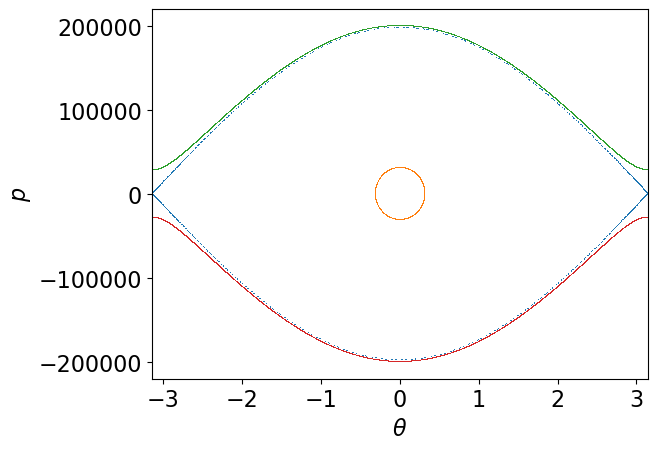

In [11]:
plt.figure(dpi=100)
plt.plot(mod_2pi(sol_theta_sep), sol_p_sep, ',')
plt.plot(mod_2pi(sol_theta_fp), sol_p_fp, ',')
plt.plot(mod_2pi(sol_theta_rotate), sol_p_rotate, ',')
plt.plot(mod_2pi(sol_theta_rotate_m), sol_p_rotate_m, ',')
plt.xlim(-np.pi, np.pi)
plt.xlabel(r"$\theta$")
plt.ylabel("$p$")
plt.show()

### Exercise

Use the energy functions, the results from the integration along the separatrix and the intial condition on the separatrix to compute and plot the energy error as a function of time.